<a href="https://colab.research.google.com/github/prateekchandrajha/mastering-ml-algorithms/blob/main/Epsilon_Greedy_UCB_Gradient_Bandits_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reinforcement Learning Assignment - 1 Due 11/02/2021

Compare the performance of these algorithm for 5 normal bandits for a horizon of 1000: 
- Let the means of the normally distributed random rewards be [−0.3, 0.0, 0.2, 0.3, 0.6] and let the variance be 1 for each of these distributions. 

- Plot the reward
of the algorithms on the same graph. 

- For the epsilon greedy
algorithm choose $\epsilon$ = 0, 0.1, 0.15, 0.2, 0.5 and for UCB let the
parameter value be 1, 2, so you will have 7 plots in the same
graph. 

- For the explore and exploit assume you pull each arm
10 times to estimate the mean. 

- To plot the reward at time instant t simulate each bandit a 1000 times and take the average.

- Finally, for each algorithm, plot the average pseudo regret as a
function of t - i.e. the pseudo regret (you know the arm with
the best mean so you can compute it) and divide by t.

- For each of the algorithms plot the average number of times an
arm was choosen upto time instant t (averaged over the 1000
simulations).

- Plot separately the number of times the optimal arm was chosen
at time t.


## First Explore and Then Only Exploit

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from random import *
np.random.seed(0)

In [59]:
# mean of each of the 5 arms

mean = [-0.3, 0.0, 0.2, 0.3, 0.6]

# diagonal covariance matrix of 0 between different bandits and variance of 1 for each bandit so IDENTITY COVARIANCE MATRIX

cov = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]] 

In [60]:
bandit_arms_played = np.random.multivariate_normal(mean, cov, 10) # Explored each of the 5 arms 10 times each
bandit_arms_played

array([[ 1.46405235,  0.40015721,  1.17873798,  2.5408932 ,  2.46755799],
       [-1.27727788,  0.95008842,  0.04864279,  0.19678115,  1.0105985 ],
       [-0.15595643,  1.45427351,  0.96103773,  0.42167502,  1.04386323],
       [ 0.03367433,  1.49407907, -0.00515826,  0.6130677 , -0.25409574],
       [-2.85298982,  0.6536186 ,  1.0644362 , -0.44216502,  2.86975462],
       [-1.75436567,  0.04575852,  0.01281615,  1.83277921,  2.06935877],
       [-0.14505257,  0.37816252, -0.68778575, -1.68079647,  0.25208785],
       [-0.14365103,  1.23029068,  1.40237985, -0.08732682,  0.29769725],
       [-1.34855297, -1.42001794, -1.50627019,  2.2507754 ,  0.09034782],
       [-0.7380743 , -1.25279536,  0.97749036, -1.31389785,  0.38725972]])

In [61]:
mean_estimate = np.mean(bandit_arms_played, axis=0) # estimating the mean of each arm using those 10 pulls
mean_estimate

array([-0.6918194 ,  0.39336152,  0.34463269,  0.43317855,  1.023443  ])

In [62]:
max_arm_index_explored = np.argmax(mean_estimate)
max_arm_index_explored # which arm has the highest mean

4

In [63]:
actual_best_arm_index = np.argmax(mean)
actual_best_arm_index

4

In [64]:
def pseudoregret(mean, mean_estimate, max_arm_index_explored, actual_best_arm_index, simulations):
    return(np.cumsum(mean[actual_best_arm_index]*np.ones(len(simulations)) - np.array(mean_estimate)[simulations]))

In [65]:
n_simulations = 1000
pseudoreg = pseudoregret(mean, mean_estimate, max_arm_index_explored, actual_best_arm_index, [max_arm_index_explored]*n_simulations)

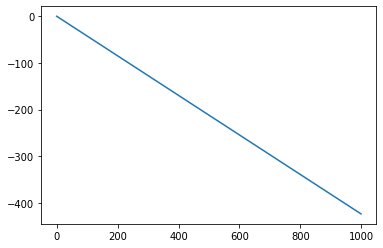

In [66]:
plt.plot(pseudoreg) # pseudoregret plot for explore and exploit when the optimal arm is not selected after mean estimation

## Epsilon Greedy

In [98]:
def ind_max(x):
  m = max(x)
  return x.index(m)

class EpsilonGreedy():
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts # Count represent counts of pulls for each arm. For multiple arms, this will be a list of counts.
        self.values = values # Value represent average reward for specific arm. For multiple arms, this will be a list of values.
        return 
    
    # Initialise k number of arms
    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
    
    # Epsilon greedy arm selection
    def select_arm(self):
        # If prob is not in epsilon, do exploitation of best arm so far
        if random.random() > self.epsilon:
            # print(self.values)
            return ind_max(self.values)
        # If prob falls in epsilon range, do exploration
        else:
            return random.randrange(len(self.values))
    
    # Choose to update chosen arm and reward
    def update(self, chosen_arm, reward):
        # update counts pulled for chosen arm
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        
        # Update average/mean value/reward for chosen arm
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

In [99]:
def test_algorithm(algo, arms, num_sims, horizon, mean, cov):
    
    # Initialise variables for duration of accumulated simulation (num_sims * horizon_per_simulation)
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims *horizon)]
    times = [0.0 for i in range (num_sims*horizon)]
    
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim -1) * horizon + t -1
            sim_nums[index] = sim
            times[index] = t
            
            # Selection of best arm and engaging it
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            
            # Obtain reward
            reward = np.random.multivariate_normal(mean, cov, 1)[0][chosen_arm]
            rewards[index] = reward
            
            if t ==1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index-1] + reward
                
            algo.update(chosen_arm, reward)
    
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

In [100]:
np.random.multivariate_normal(mean, cov, 1)[0]

array([-1.18158446, -1.3328738 , -1.24541293, -0.9362822 ,  1.83233878])


100%|██████████| 5/5 [00:00<00:00,  7.37it/s]


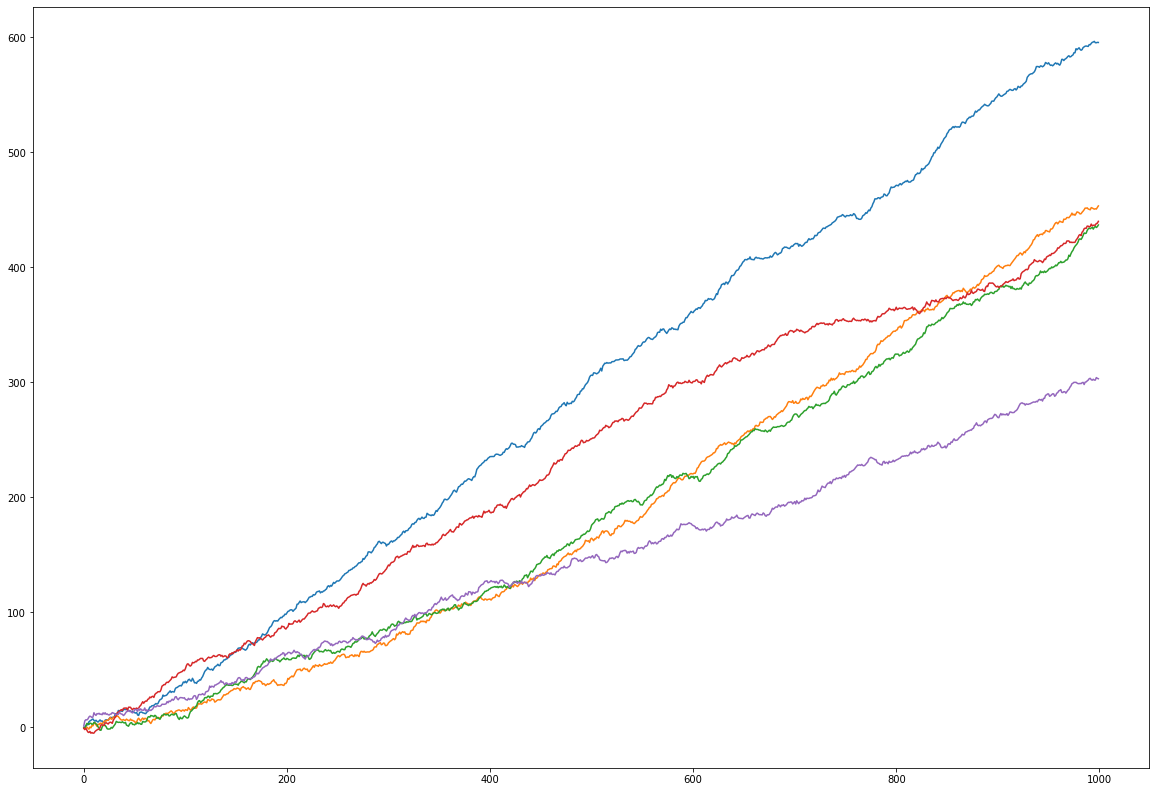

In [120]:
n_arms=5
import random
from tqdm import tqdm 
import seaborn as sns

fig = plt.figure(figsize=(20,14))
for epsilon in tqdm(range(1,6)):
    algo = EpsilonGreedy(epsilon*0.1, [], [])
    algo.initialize(n_arms)
    results = test_algorithm(algo, mean, 1, 1000, mean, cov)
    plt.plot(results[4])
# plt.bar(results[2])
plt.show()
# ax = sns.countplot(x="class", data=results[2])

## UCB

In [122]:
import math

def ind_max(x):
  m = max(x)
  return x.index(m)

class UCB1():
  def __init__(self, counts, values):
    self.counts = counts
    self.values = values
    return
  
  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    return
  
  def select_arm(self):
    n_arms = len(self.counts)
    for arm in range(n_arms):
      if self.counts[arm] == 0:
        return arm

    ucb_values = [0.0 for arm in range(n_arms)]
    total_counts = sum(self.counts)
    for arm in range(n_arms):
      bonus = math.sqrt((2 * math.log(total_counts)) / float(self.counts[arm]))
      ucb_values[arm] = self.values[arm] + bonus
    return ind_max(ucb_values)
  
  def update(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]

    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value
    return

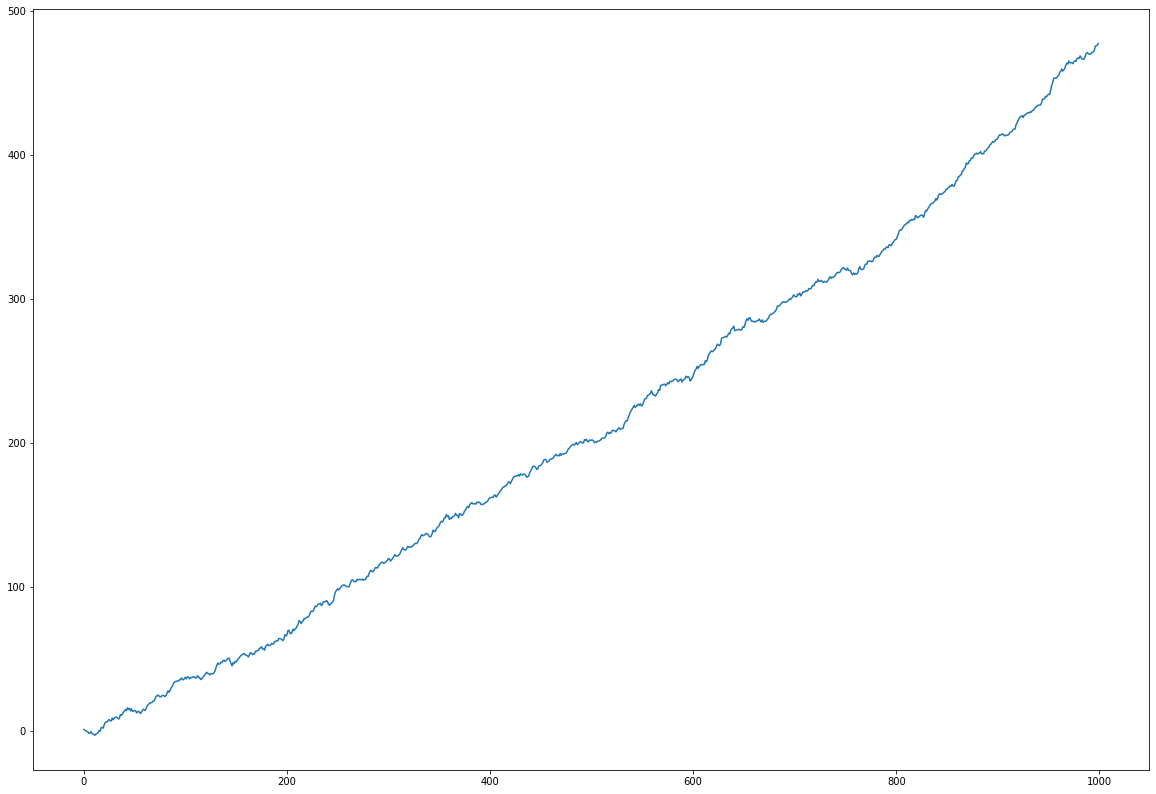

In [123]:
n_arms=5
# import random
# from tqdm import tqdm 
# import seaborn as sns

fig = plt.figure(figsize=(20,14))

# for epsilon in tqdm(range(1,6)):
algo = UCB1([], [])
algo.initialize(n_arms)
results = test_algorithm(algo, mean, 1, 1000, mean, cov)
plt.plot(results[4])
# plt.bar(results[2])
plt.show()
# ax = sns.countplot(x="class", data=results[2])

## Epsilon going down with each time step ( $\epsilon$ going down to $\epsilon/t$ )

In [132]:
def ind_max(x):
  m = max(x)
  return x.index(m)

class EpsilonGreedyChanging():
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts # Count represent counts of pulls for each arm. For multiple arms, this will be a list of counts.
        self.values = values # Value represent average reward for specific arm. For multiple arms, this will be a list of values.
        return 
    
    # Initialise k number of arms
    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
    
    # Epsilon greedy arm selection
    def select_arm(self,t):
        # If prob is not in epsilon, do exploitation of best arm so far
        if random.random() > self.epsilon/t:
            # print(self.values)
            return ind_max(self.values)
        # If prob falls in epsilon range, do exploration
        else:
            return random.randrange(len(self.values))
    
    # Choose to update chosen arm and reward
    def update(self, chosen_arm, reward):
        # update counts pulled for chosen arm
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        
        # Update average/mean value/reward for chosen arm
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

In [133]:
def test_algorithm(algo, arms, num_sims, horizon, mean, cov):
    
    # Initialise variables for duration of accumulated simulation (num_sims * horizon_per_simulation)
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims *horizon)]
    times = [0.0 for i in range (num_sims*horizon)]
    
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim -1) * horizon + t -1
            sim_nums[index] = sim
            times[index] = t
            
            # Selection of best arm and engaging it
            if t==0:
              chosen_arm = algo.select_arm(1)
            else:
              chosen_arm = algo.select_arm(t)
            chosen_arms[index] = chosen_arm
            
            # Obtain reward
            reward = np.random.multivariate_normal(mean, cov, 1)[0][chosen_arm]
            rewards[index] = reward
            
            if t ==1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index-1] + reward
                
            algo.update(chosen_arm, reward)
    
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]


100%|██████████| 5/5 [00:00<00:00,  6.01it/s]


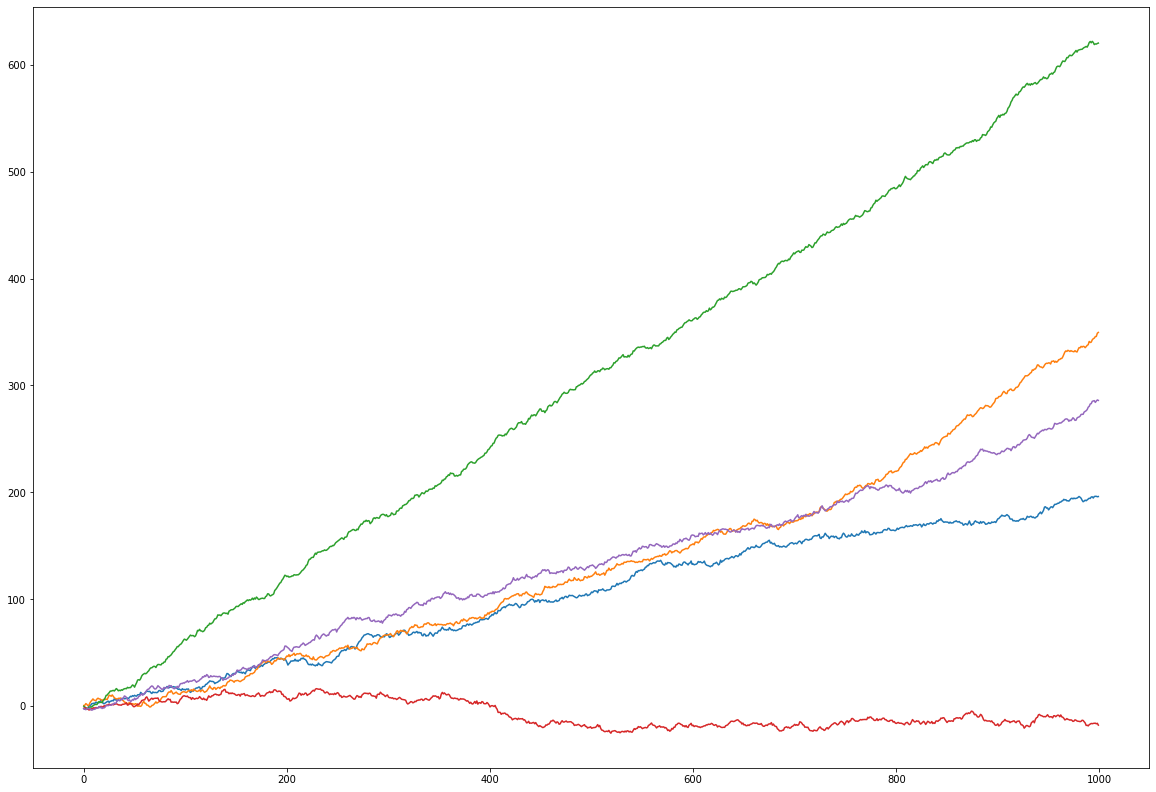

In [135]:
n_arms=5
# import random
# from tqdm import tqdm 
# import seaborn as sns

fig = plt.figure(figsize=(20,14))
for epsilon in tqdm(range(1,6)):
    algo = EpsilonGreedyChanging(epsilon*0.1, [], [])
    algo.initialize(n_arms)
    results = test_algorithm(algo, mean, 1, 1000, mean, cov)
    plt.plot(results[4])
# plt.bar(results[2])
plt.show()
# ax = sns.countplot(x="class", data=results[2])

## Gradient Bandit Algorithm Using Our Starting Mean Estimates (Barto-Sutton)

In [128]:
def get_reward(mean, cov):
    return np.random.multivariate_normal(mean, cov, 1)[0] # [chosen_arm]np.random.randn(10) + mean

def softmax(H):
    h = H - np.max(H)
    exp = np.exp(h)
    return exp / np.sum(exp)

def gradient_bandit(N,mean,cov):
    H = np.zeros(5) # preference
    r_hist = []
    alpha = 0.1 
    for t in range(1, N):
        policy = softmax(H) # policy pi

        # sampling (choice) action by policy
        a = np.random.choice(5, p=policy) 

        rewards = get_reward(mean, cov)

        r = rewards[a] # R_t (reward for chosen action)
        r_hist.append(r)
        avg_r = np.average(r_hist)
        # update a == A_t (chosen action)
        H[a] = H[a] + alpha*(r-avg_r)*(1-policy[a])
        # update a != A_t (non-chosen action)
        H[:a] = H[:a] - alpha*(r-avg_r)*policy[:a]
        H[a+1:] = H[a+1:] - alpha*(r-avg_r)*policy[a+1:]
    
    return softmax(H), r_hist


In [129]:
opt_policy, r_hist = gradient_bandit(10000,mean,cov)

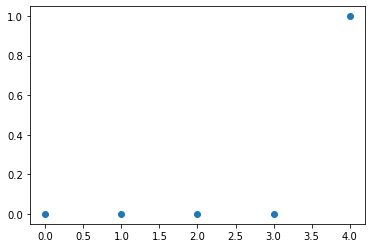

In [131]:
plt.plot(opt_policy, 'o') # Arm 4 gets selected